In [ ]:
import mne
import scipy
import pandas as pd
import numpy as np
import cebra
from cebra import CEBRA
import cebra.models
import matplotlib.pyplot as plt

In [ ]:
preprocess_dir = '../../data/SEED/SEED_EEG/Preprocessed_EEG'
extracted_dir = '../../data/SEED/SEED_EEG/ExtractedFeatures'
fq = 200
channels = 62
out_dimensions = 8
persons = 15
sessions = 3
sectors = 15
epochSize = 200
epochStride = 100

# files = [['1_20131027', '1_20131030', '1_20131107'],
#          ['2_20140404', '2_20140413', '2_20
# eegs = scipy.io.loadmat(preprocess_dir + '/1_20131030.mat')
labels = scipy.io.loadmat(preprocess_dir + '/label.mat')['label'][0]

In [ ]:
import os
files = os.listdir(preprocess_dir)
files.sort()
files = np.asarray(files)[: sessions * persons]

key_prefix = ['ww', 'ww', 'ww', 'wsf', 'wsf', 'wsf', 'wyw', 'wyw', 'wyw',
              'xyl', 'xyl', 'xyl', 'ys', 'ys', 'ys', 'zjy', 'zjy', 'zjy',
              'djc', 'djc', 'djc', 'jl', 'jl', 'jl', 'jj', 'jj', 'jj',
              'lqj', 'lqj', 'lqj', 'ly', 'ly', 'ly', 'mhw', 'mhw', 'mhw',
              'phl', 'phl', 'phl', 'sxy', 'sxy', 'sxy', 'wk', 'wk', 'wk']

In [ ]:
iter = 10000
batch_size = 1024

time_train = np.empty([0, channels])
time_test = np.empty([0, channels])
emo_labels_train = np.empty([0, ], dtype=np.int32)
emo_labels_test = np.empty([0, ], dtype=np.int32)
subject_labels_train = np.empty([0, ], dtype=np.int32)
subject_labels_test = np.empty([0, ], dtype=np.int32)

提取特征矩阵，划分数据集

In [ ]:
test_ratio = 0.1
mod = (int)(1 / test_ratio)

for f in range(files.shape[0]):  
    eegs = scipy.io.loadmat(f'{preprocess_dir}/{files[f]}')
    epochs_time = np.empty([0, channels])
    epoch_time_labels = np.empty([0, ], dtype=np.int32)
    # per sector
    for i in range(1, sectors + 1):
        k = f'{key_prefix[f]}_eeg{str(i)}'
        epoch = eegs[k].swapaxes(0, 1)
        label = np.full((epoch.shape[0], ), labels[i - 1], dtype=np.int32)
        subject_label = np.full((epoch.shape[0], ), f // sessions, dtype=np.int32)
        index = files.shape[0] * sectors + i
        if index % mod == 0:
            time_test = np.append(time_test, epoch, axis=0)
            emo_labels_test = np.append(emo_labels_test, label)
            subject_labels_test = np.append(subject_labels_test, subject_label)
        else:
            
            print(time_train.shape, epoch.shape)
            time_train = np.append(time_train, epoch, axis=0)
            emo_labels_train = np.append(emo_labels_train, label)
            subject_labels_train = np.append(subject_labels_train, subject_label)

emo_labels_train = emo_labels_train + 1
emo_labels_test = emo_labels_test + 1
print(time_train.shape, emo_labels_train.shape, subject_labels_train.shape)
with open('time.npy', 'wb') as f:
    np.save(f, time_train)
    np.save(f, time_test)
    np.save(f, emo_labels_train)
    np.save(f, emo_labels_test)
    np.save(f, subject_labels_train)
    np.save(f, subject_labels_test)

In [ ]:
with open('time.npy', 'rb') as f:
    time_train = np.load(f)
    time_test = np.load(f)
    emo_labels_train = np.load(f)
    emo_labels_test = np.load(f)
    subject_labels_train = np.load(f)
    subject_labels_test = np.load(f)

训练模型

In [ ]:
models = [['offset1-model', 1], ['offset10-model', 10]]

offset1-model
offset10-model


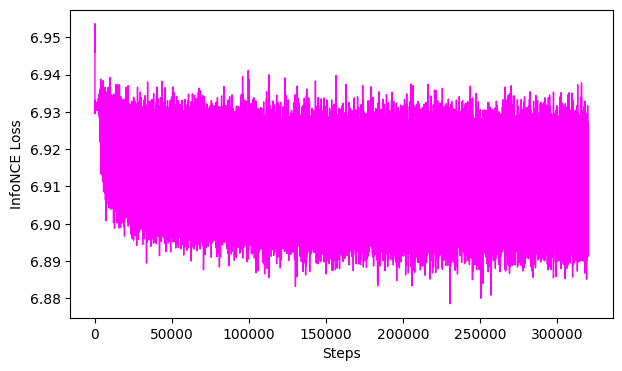

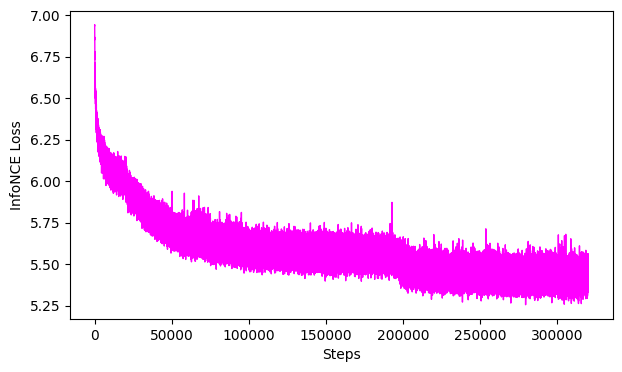

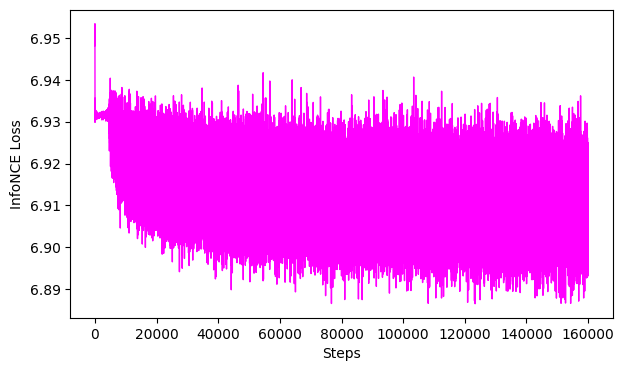

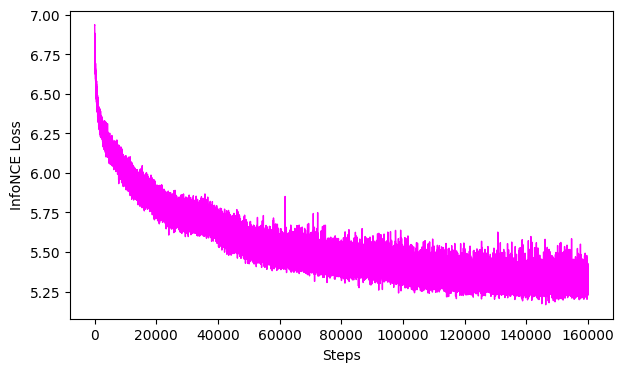

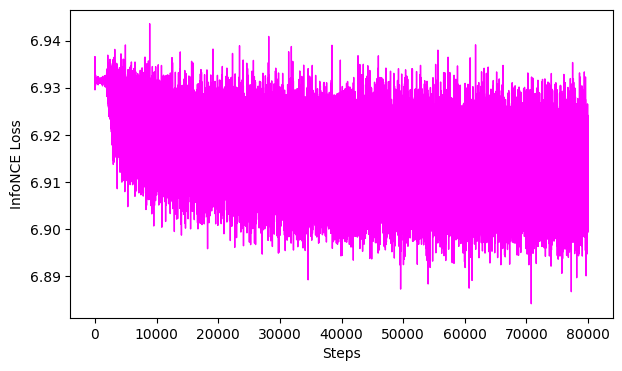

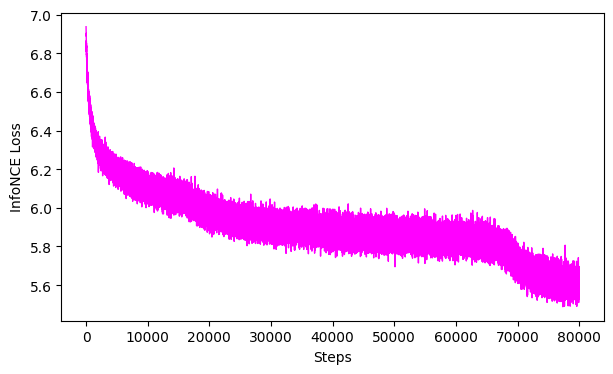

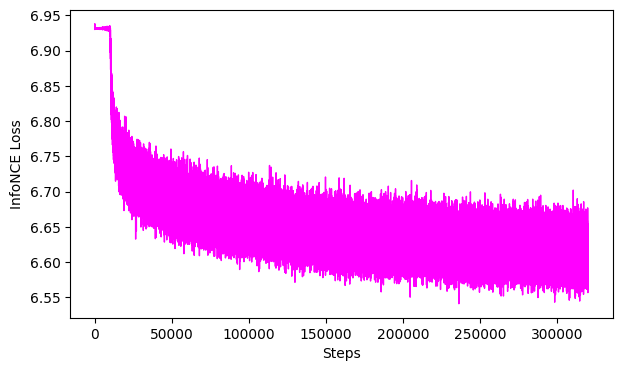

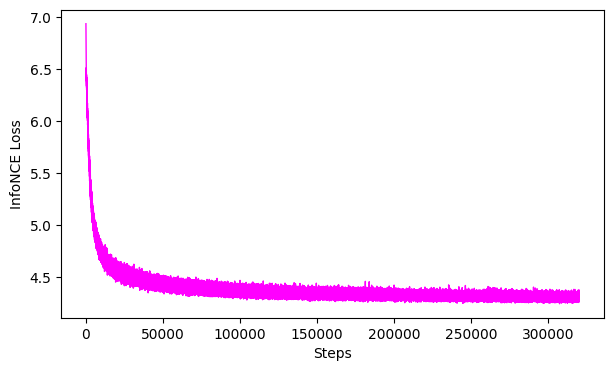

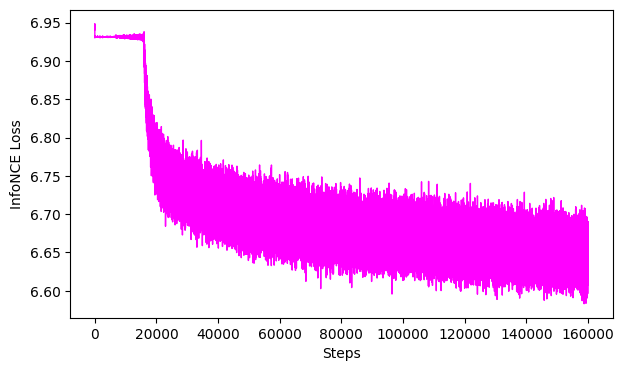

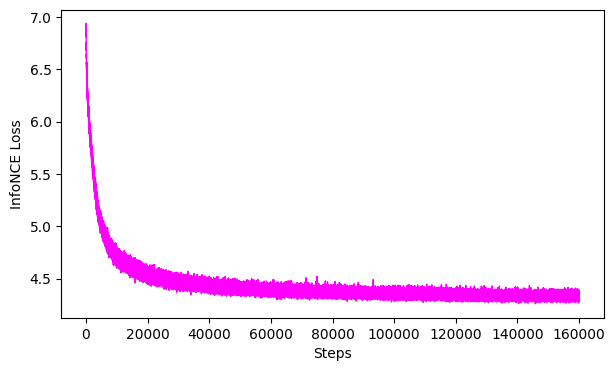

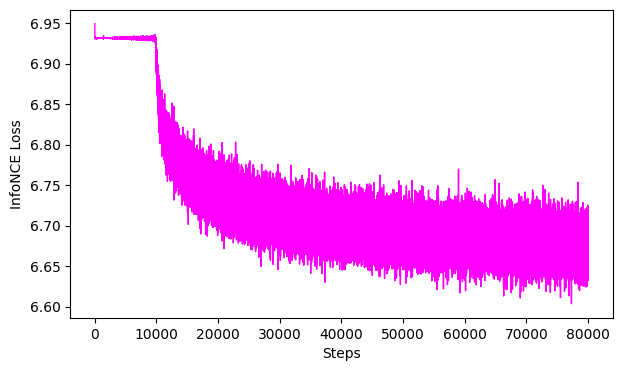

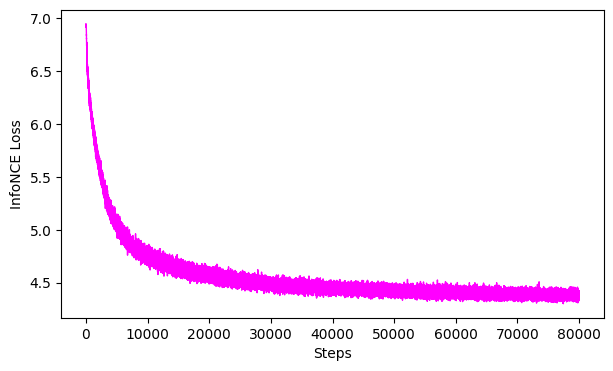

In [11]:
iter = 40000
for model_name, offset in models:
    print (model_name)
    for d in [32, 16, 8]:
        for use_label in ['emo', 'subject']:
            cebra_model = CEBRA(
                model_architecture = model_name,
                batch_size = batch_size,
                temperature_mode="auto",
                learning_rate = 0.001,
                max_iterations = iter * d // 4,
                time_offsets = offset,
                output_dimension = d,
                device = "cuda_if_available",
                verbose = False
            )
            if use_label == 'emo':
                cebra_model.fit(time_train, emo_labels_train)
            elif use_label == 'subject':
                cebra_model.fit(time_train, subject_labels_train)
            else:
                cebra_model.fit(time_train)
            cebra_model.save(f'time_{model_name}_d{d}_i{iter * d}_label{use_label}.model')
            cebra.plot_loss(cebra_model)

使用KNN进行分类

In [ ]:
from sklearn import svm
from joblib import dump, load
decoder = svm.NuSVC(gamma="auto")

iter = 10000
# decoder = cebra.KNNDecoder()

models = [['offset1-model', 1]]
for model_name, offset in models:
    for d in [32]:
        for use_label in ['emo']:
            cebra_model = cebra.CEBRA.load(f'time_{model_name}_d{d}_i{iter}_label{use_label}.model')
            embeddings_train = cebra_model.transform(time_train)
            embeddings_test = cebra_model.transform(time_test)
            cebra.plot_embedding(embeddings_train, embedding_labels='time')
            cebra.plot_embedding(embeddings_test, embedding_labels='time')
            if True or (use_label == 'none' or use_label == 'emo'):
                decoder.fit(embeddings_train, subject_labels_train.flatten())
                dump(decoder, f'time_{model_name}_d{d}_i{iter}_label{use_label}_decode_subject_knn.clf')
                predict_labels_train = decoder.predict(embeddings_train)
                predict_labels_test = decoder.predict(embeddings_test)
                print(predict_labels_train, predict_labels_test)
                acc_train = np.sum(predict_labels_train == subject_labels_train.flatten()) / predict_labels_train.shape[0]
                acc_test = np.sum(predict_labels_test == subject_labels_test.flatten()) / predict_labels_test.shape[0]
                print(acc_train, acc_test)
            if True or use_label == 'none' or use_label == 'subject':
                decoder.fit(embeddings_train, emo_labels_train.flatten())
                dump(decoder, f'time_{model_name}_d{d}_i{iter}_label{use_label}_decode_emo_knn.clf')
                # decoder = load(f'de_{model_name}_d{d}_i{iter}_label{use_label}_decode_emo_NuSVC.clf')
                predict_labels_train = decoder.predict(embeddings_train)
                predict_labels_test = decoder.predict(embeddings_test)
                print(predict_labels_train, emo_labels_train)
                print(predict_labels_test, emo_labels_test)
                acc_train = np.sum(predict_labels_train == emo_labels_train.flatten()) / predict_labels_train.shape[0]
                acc_test = np.sum(predict_labels_test == emo_labels_test.flatten()) / predict_labels_test.shape[0]
                print(acc_train, acc_test)